# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

Specific programming tasks are marked with a **ToDo** tag. 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will use my different tools and what I learned about statics in this chapter to check and understanding the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.


>**Tip**: Please save your work regularly.

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
#read dataset from ab_data.csv and show 3 rows
df = pd.read_csv("ab_data.csv")
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
# show the total number of rows & number of columns
df.shape

(294478, 5)

**c.** The number of unique users in the dataset.

In [4]:
#calculate the number of unique users
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [5]:
# calculate the proportion of users converted
df.converted.mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
#calculate the number of times when the "group" is treatment but "landing_page" is not a new_page
df.query('(group=="treatment" and landing_page!="new_page")or(group !="treatment" and landing_page=="new_page")')["user_id"].count()

3893

**f.** Do any of the rows have missing values?

In [7]:
#check the number of rows in each column and if we have any missing
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


### 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.drop(df.query('(group=="treatment" and landing_page!="new_page")or(group !="treatment" and landing_page=="new_page")or(group=="control" and landing_page!="old_page")or(group !="control" and landing_page=="old_page")').index)

In [9]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [10]:
#calculate the number of unique user_ids
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [11]:
#find out the repeated user
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

**c.** Display the rows for the duplicate **user_id**? 

In [12]:
#Display the rows for the duplicate user_id
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [13]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2.drop(labels=2893,inplace=True)
# Check again if the row with a duplicate user_id is deleted or not
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [14]:
# Check again if the row with a duplicate user_id is deleted or not
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted


### 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

>**Tip**: The probability  you'll compute represents the overall "converted" success rate in the population and you may call it $p_{population}$.



In [15]:
#calculate the probability of an individual converting regardless of the page they receive
df2.converted.mean()

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
#Display the probability of converted for control group
conv_cont = df2.query('group=="control"')["converted"].mean()
conv_cont

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
#Display the probability of converted for treatment group
conv_tre = df2.query('group=="treatment"')["converted"].mean()
conv_tre

0.11880806551510564

>**Tip**: The probabilities you've computed in the points (b). and (c). above can also be treated as conversion rate. 
Calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups. You will need that later.  

In [18]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff =  conv_tre - conv_cont  
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [19]:
#calculate the probability that an individual received the new page
new_page = df2.query('landing_page == "new_page" and group =="treatment"')["converted"].count()/df2.shape[0]
new_page

0.50006194422266881

In [20]:
#calculate the probability that an individual received the old page
old_page = df2.query('landing_page == "old_page" and group =="control"')["converted"].count()/df2.shape[0]
old_page


0.49993805577733119

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

From my results found no preferance between converted treatment group and converted control group that the probability of converted for control group(12%) that almost equal the probability of converted for treatment group(11.88%). and also the probability that an individual received the new page (50%), when the probability that an individual received the old page (49.99%). At last the population (290584 users) is divided half of them received the old page, and another half received the new page. 

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

Null Hypothesis **$H_0$:    𝑝𝑜𝑙𝑑 >= 𝑝𝑛𝑒𝑤**

The probability for the old page greater than or equal the probability for the new page.

Alternative Hypothesis **$H_1$:    𝑝𝑜𝑙𝑑 < 𝑝𝑛𝑒𝑤**

The probability for the new page greater than the probability for the old page.

### 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, I will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [21]:
# calculate converted probability for new page
𝑝𝑛𝑒𝑤 = df2.converted.mean()
𝑝𝑛𝑒𝑤

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [22]:
# calculate converted probability for old page
𝑝𝑜𝑙𝑑 = df2.converted.mean()
𝑝𝑜𝑙𝑑

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [23]:
# calculate the number of individuals in the treatment group
𝑛𝑛𝑒𝑤 = df2.query('landing_page=="new_page"').count()[0]
𝑛𝑛𝑒𝑤

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [24]:
# calculate the number of individuals in the control group
𝑛𝑜𝑙𝑑 = df2.query('landing_page=="old_page"').count()[0]
𝑛𝑜𝑙𝑑

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [25]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1], size = 𝑛𝑛𝑒𝑤,p=(𝑝𝑛𝑒𝑤,1- 𝑝𝑛𝑒𝑤))
new_page_converted.mean()

0.88000825820659279

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [26]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1], size = 𝑛𝑜𝑙𝑑, p=(𝑝𝑜𝑙𝑑,1- 𝑝𝑜𝑙𝑑))
old_page_converted.mean()

0.88162369040571609

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [27]:
# calculate the difference in the "converted" probability
diff_conv_P = new_page_converted.mean() - old_page_converted.mean()
diff_conv_P

-0.0016154321991233012


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [28]:
# Sampling distribution for 10000 times
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(𝑛𝑛𝑒𝑤, 𝑝𝑛𝑒𝑤, 10000)/𝑛𝑛𝑒𝑤
    old_page_converted = np.random.binomial(𝑛𝑜𝑙𝑑, 𝑝𝑜𝑙𝑑, 10000)/𝑛𝑜𝑙𝑑
    p_diffs = new_page_converted - old_page_converted

In [29]:
#convert to numpy array
p_diffs = np.array(p_diffs)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

>**Tip**: Display title, x-label, and y-label in the chart.

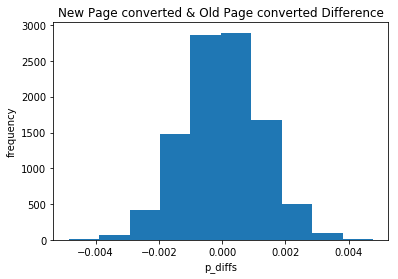

In [30]:
#Plot a histogram of the p_diffs
plt.hist(p_diffs);
plt.xlabel('p_diffs');
plt.ylabel('frequency');
plt.title('New Page converted & Old Page converted Difference');

In [31]:
#create distribution under the null hypothesis
null_vals = np.random.normal(0,p_diffs.std(),df2.shape[0])

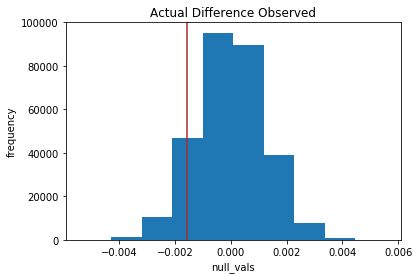

In [32]:
#plot null distribution
plt.hist(null_vals);
plt.axvline(obs_diff, c ='brown');
plt.xlabel('null_vals');
plt.ylabel('frequency');
plt.title('Actual Difference Observed');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [33]:
#calculate the proportion of p_diffs greater than the observed in df2 data
(p_diffs > obs_diff).mean()

0.90780000000000005

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

From previous point we can estimate proportion of p_diffs is greater than the actual difference observed in ab_data.csv by 90%.
In scientific studies this value is called p-value. Here p-value > α (α = 5 %), so null Hypothesis ($H_0$) fail to reject that mean the data can't prove alternatve hypothesis. So also here we can't prove the new page has higher conversion rate than old page.




**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [34]:
# number of conversions with the old_page
convert_old = df2.query('converted == 1 and landing_page == "old_page"').count()[0]
# number of conversions with the new_page
convert_new = df2.query('converted == 1 and landing_page == "new_page"').count()[0]

# number of individuals who were shown the old_page
n_old = df2.query('landing_page=="old_page"').count()[0]

# number of individuals who received new_page
n_new = df2.query('landing_page=="new_page"').count()[0]
convert_old, convert_new, n_old, n_new 


(17489, 17264, 145274, 145310)

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 
>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

>**Tip**: You don't have to dive deeper into z-test for this exercise. **Try having an overview of what does z-score signify in general.** 

In [35]:
import statsmodels.api as sm
# Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]),alternative = 'larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>**Tip**: Notice whether the p-value is similar to the one computed earlier. Accordingly, can you reject/fail to reject the null hypothesis? It is important to correctly interpret the test statistic and p-value.

The value of $Z_{score}$ = -1.3 that less than the critical value of $Z_{0.05}$, that it mean fail to reject null hypothesis. here also we calculated p_value, that we found this result is similar to the one computed earlier that the old page users have better or equal converted rate than new page users. 

<a id='regression'></a>
### Part III - A regression approach

### 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

Logestic Regression because of the response variable is categorical variable, and also it's multiple regression but with an outcome variable and predictor variables that are continuous

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [36]:
#set intercept = 1
df2['intercept'] = 1
#create dummy variable column for group column
group_dummies = pd.get_dummies(df2['group'])
#join new column with df2
df2 = df2.join(group_dummies)
# rename treatment column to ab_page
df2 = df2.rename(columns = {'treatment' : 'ab_page'})
#display 3 rows
df2.head(3)


,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [37]:
#import scipy library, and fit Logit regression model
from scipy import stats
stats.chisqprob = lambda chisq, df3: stats.chi2.sf(chisq,df3)


LM = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = LM.fit()



Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
#make the summary of Logit regression model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 06 Jan 2022   Pseudo R-squ.:               8.077e-06
Time:                        12:59:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**Hints**: 
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- You may also compare the current p-value with the Type I error rate (0.05).


The p-value associated with ab_page is 19% is different than what we found in part II, because of null and alternative hypothesis there assumed as equal probability of old page and new page converted, and also it was one tail test. But here the Logestic regression is two tailed test. 

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

I consider the (age) that we can divide population into children, youth, adult, and old people according to their age. And check which age attract to which page, and what are they intersted for each interval. But the disadvantage of my considering is continous changing of each interval because of changing of age.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

In [39]:
# Read the countries.csv
df4 = pd.read_csv("countries.csv")
df4.head(3)

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK


In [40]:
# Join with the df2 dataframe
df_merged = df2.merge(df4)
df_merged.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US


In [41]:
# Create the necessary dummy variables
df_merged[['CA','UK','US']] = pd.get_dummies(df_merged['country'])
df_merged = df_merged.drop('country',1)
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,0,0,1


**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

>**Tip**: Conclusions should include both statistical reasoning, and practical reasoning for the situation. 

>**Hints**: 
- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can you reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


In [42]:
# Fit your model, and summarize the results
df_merged['US_ab_page'] = df_merged['US'] * df_merged['ab_page']
df_merged['UK_ab_page'] = df_merged['UK'] * df_merged['ab_page']
df_merged['CA_ab_page'] = df_merged['CA'] * df_merged['ab_page']

In [43]:
df2['intercept'] = 1
Log_cnty = sm.Logit(df_merged['converted'],df_merged[['intercept','ab_page','UK','US','UK_ab_page','US_ab_page']])
results = Log_cnty.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 06 Jan 2022   Pseudo R-squ.:               3.482e-05
Time:                        13:00:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK_ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
US_ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

In conclusion, we have not enough evidence that the new_page conversion is more than the old_page. This is based on the probability figures, A/B test and regression. There is no any additional evidence that the countries (US, CA and UK) change the probability of conversion.
From the above Logit Regression Results, we can note the coefficient of intereaction variable "UK_new_page" and "US_new_page" are different from the coefficient of new_page itself.

Also,only intercept's p-value is less than 0.05, which is statistically significant enough for converted rate. Other variables in the summary are not statistically significant. Additionally, Z-score for all X variables are not large enough to be significant for predicting converted rate.

Therefore, the country a user lives is not significant on the converted rate considering the page the user land in.

Since the sample size is large continuing the testing of the new_page is likely not necessary. It is best to focus on the development of another new landing page.

Limitation I faced a problem when try to import statsmodels as sm to calculate logit for fitting. It took around 3 days to solve it when I read alot and try in my local VS Code, and also tried in jupyter notebook under anaconda. I checked to import statsmodels as sm but failure, found an opinion to try statsmodels.api as sm but fail also, while that found this message "Please use the pandas.tseries module instead. from pandas.core import datetools", So I import this recommendation but failed.
Tried to import "from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression". No success, so start to think may I have problem of Logit code, so I came back to study lesson for another time and come back.
One of my attempts found message about scipy and chisqprob, that I searched about this mention.
At last I got the solution as you saw.



<a id='finalcheck'></a>
## Final Check!

Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your notebook to make sure that it satisfies all the specifications mentioned in the rubric. You should also probably remove all of the "Hints" and "Tips" like this one so that the presentation is as polished as possible.


<a id='submission'></a>
## Submission
You may either submit your notebook through the "SUBMIT PROJECT" button at the bottom of this workspace, or you may work from your local machine and submit on  the last page of this project lesson.  

1. Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).


2. Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.


3. Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [44]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0